In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Сбор данных

In [ ]:
import requests
import time

VK_TOKEN = 'VK_TOKEN' # токен для аутентификации и доступа к API VK
group_id = '-132711327'

# Функция для получения постов со стены группы VK
def get_wall_posts(VK_TOKEN: str, group_id: str) -> dict:
    url = 'https://api.vk.com/method/wall.get'
    params = {
        'access_token': VK_TOKEN,
        'owner_id': group_id,
        'v': '5.154',
        'offset': '0',
        'count': '1'
    }
    response = requests.get(url, params=params)
    return response.json()

wall_posts = get_wall_posts(VK_TOKEN, group_id)
# Создание пустого датафрейма с заданными столбцами
data_posts = pd.DataFrame(columns=['id_group', 'id_post', 'date', 'description', 'title', 'text', 'views', 'likes', 'reposts'])

# Инициализация счетчика j значением длины датафрейма data_posts
j = len(data_posts)

# Максимальное количество постов для получения
count_posts = wall_posts['response']['count']

# Инициализация счетчика c
c = 0
while c <= count_posts:

    # Функция для получения постов со стены группы VK с указанием смещения
    def get_wall_posts(VK_TOKEN: str, group_id: str) -> dict:
        url = 'https://api.vk.com/method/wall.get'
        params = {
            'access_token': VK_TOKEN,
            'owner_id': group_id,
            'v': '5.154',
            'offset': str(c),
            'count': '100'
        }

        response = requests.get(url, params=params)
        return response.json()

    wall_posts = get_wall_posts(VK_TOKEN, group_id)

    # Получение постов со стены группы VK
    for i in range(len(wall_posts['response']['items'])):
        try:
            link = wall_posts['response']['items'][i]
            description = link['description']
            title = link['title']
        except:
            try:
                video = wall_posts['response']['items'][i]['attachments'][0]['video']
                description = video['description']
                title = video.get('title', None)
            except:
                try:
                    photo = wall_posts['response']['items'][i]['attachments'][0]['photo']
                    description = photo['description']
                    title = photo['title']
                except:
                    description, title = '','' # Обработка исключений и получение значений описания (description) и заголовка (title) поста

        if 'views' not in wall_posts['response']['items'][i]: # Пропуск поста, если отсутствует информация о просмотрах
            continue

        # Добавление данных поста в датафрейм
        if wall_posts['response']['items'][i]['id'] in list(data_posts['id_post']):
            index = data_posts[data_posts['id_post'] == wall_posts['response']['items'][i]['id']].index[0]
            data_posts.loc[index] = [wall_posts['response']['items'][i]['owner_id'],
                                    wall_posts['response']['items'][i]['id'],
                                    wall_posts['response']['items'][i]['date'],
                                    description,
                                    title,
                                    wall_posts['response']['items'][i]['text'],
                                    wall_posts['response']['items'][i]['views']['count'],
                                    wall_posts['response']['items'][i]['likes']['count'],
                                    wall_posts['response']['items'][i]['reposts']['count']
                                    ]
        else:
            data_posts.loc[len(data_posts)] = [wall_posts['response']['items'][i]['owner_id'],
                                    wall_posts['response']['items'][i]['id'],
                                    wall_posts['response']['items'][i]['date'],
                                    description,
                                    title,
                                    wall_posts['response']['items'][i]['text'],
                                    wall_posts['response']['items'][i]['views']['count'],
                                    wall_posts['response']['items'][i]['likes']['count'],
                                    wall_posts['response']['items'][i]['reposts']['count']
                                    ]
        j += 1

    c += 100
    time.sleep(1)


Тинькофф Журнал, или Т—Ж, — это медиа о личных финансах и жизни в России. Тут можно почитать о том, как вести семейный бюджет и отстаивать свои права, как оформить налоговые вычеты или даже выбрать технику и не переплатить за лишние функции.

In [23]:
data = pd.read_csv('data_posts_tinkoffjournal1.csv')

In [3]:
data.head(5)

,id_group,id_post,date,description,title,text,views,likes,reposts
0,-132711327,196668,1697293803,NaN,NaN,ДРЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЛЬ \nТОООООООООПООООООООТ\nПЫ...,1152,7,6
1,-132711327,196667,1697288404,NaN,NaN,«Мой самый впечатляющий и дорогой ужин случилс...,2289,3,0
2,-132711327,196666,1697283000,NaN,NaN,А вы кого считаете богатым?,4280,25,16
3,-132711327,196665,1697277607,NaN,NaN,«В конце 2020 года мы с коллегами решили сыгра...,3941,14,9
4,-132711327,196660,1697272204,NaN,NaN,"Начнем с самого неожиданного: \n\n🌜 Важно ли, ...",4441,24,46


In [24]:
data.shape

(21164, 9)

2. Предобработка текстовых данных

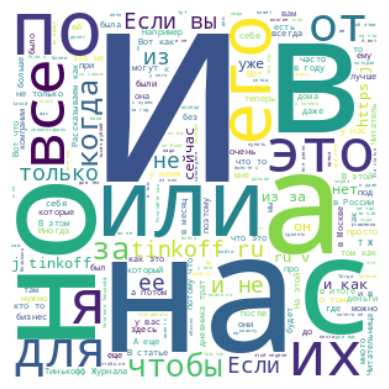

In [4]:
#Предобработка данных

#облако слов, если захотим сделать для всех постов
from wordcloud import WordCloud

# Объединение всех строк из столбца 'text' в одну строку
text = ' '.join(data['text'].astype(str))

# Создание облака слов
wc = WordCloud(width=300, height=300, background_color="white")
wc.generate(text)

# Отрисовка облака слов
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [5]:
#Токенизация и удаление пунктуации
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from string import punctuation

In [7]:
#записываем в переменную punctuations список существующих пунктуационных знаков
punctuations = list(punctuation)
punctuations.extend(['«', '»', '„', '“', '...', '—'])
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '«', '»', '„', '“', '...', '—']


In [8]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend(['который', 'это', 'такой', 'всё', 'ещё', 'весь'])
print(stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Лемматизация
!pip install pymorphy2

In [10]:
import pymorphy2

#записываем в morph лемматизатор
morph = pymorphy2.MorphAnalyzer()

In [11]:
# Функция для предобработки текста
def preprocessing(text):
  tokens = word_tokenize(text)
  tokens_without_punct = [i for i in tokens if i not in punctuations]
  low_tokens = [i.lower() for i in tokens_without_punct]
  lemms = [morph.parse(i)[0].normal_form for i in low_tokens]
  words_without_stop = [i for i in lemms if i not in stopwords]
  return ' '.join(words_without_stop)

In [12]:
# Преобразование значений столбца 'text' в строки
data['text'] = data['text'].astype(str)

# Применение функции preprocessing к столбцу 'text' и создание нового столбца 'preprocessed_text'
data['preprocessed_text'] = data['text'].apply(preprocessing)


# Сохраняем DataFrame с предобработанным текстом в новый CSV-файл
data.to_csv('preprocessed_data.csv', index=False)

In [13]:
data.head(5)

,id_group,id_post,date,description,title,text,views,likes,reposts,preprocessed_text
0,-132711327,196668,1697293803,NaN,NaN,ДРЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЛЬ \nТОООООООООПООООООООТ\nПЫ...,1152,7,6,дрееееееееееееееель тооооооооопоооооооот пылес...
1,-132711327,196667,1697288404,NaN,NaN,«Мой самый впечатляющий и дорогой ужин случилс...,2289,3,0,самый впечатляющий дорога ужин случиться копен...
2,-132711327,196666,1697283000,NaN,NaN,А вы кого считаете богатым?,4280,25,16,считать богатый
3,-132711327,196665,1697277607,NaN,NaN,«В конце 2020 года мы с коллегами решили сыгра...,3941,14,9,конец 2020 год коллега решить сыграть тайный с...
4,-132711327,196660,1697272204,NaN,NaN,"Начнем с самого неожиданного: \n\n🌜 Важно ли, ...",4441,24,46,начать неожиданный 🌜 важно время ложиться спат...


In [14]:
data.shape

(21164, 10)

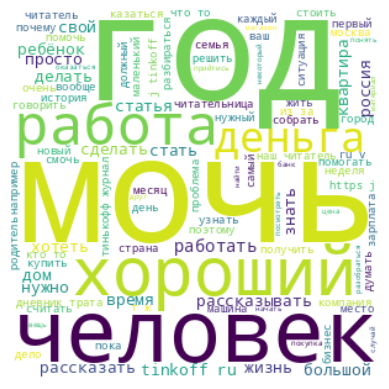

In [15]:
# Объединение всех строк из столбца 'text' в одну строку
preprocessed_text = ' '.join(data['preprocessed_text'].astype(str))


# Создание облака слов
wc = WordCloud(width=300, height=300, background_color="white")
wc.generate(preprocessed_text)

# Отрисовка облака слов
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

3. Использование предобученной модели для анализа тональности

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Загрузка модели и токенизатора
model_name = "blanchefort/rubert-base-cased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Создание пайплайна для анализа тональности
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

data['sentiment'] = data['preprocessed_text'].apply(lambda x: nlp(x)[0]['label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [17]:
data.head()

,id_group,id_post,date,description,title,text,views,likes,reposts,preprocessed_text,sentiment
0,-132711327,196668,1697293803,NaN,NaN,ДРЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЛЬ \nТОООООООООПООООООООТ\nПЫ...,1152,7,6,дрееееееееееееееель тооооооооопоооооооот пылес...,NEGATIVE
1,-132711327,196667,1697288404,NaN,NaN,«Мой самый впечатляющий и дорогой ужин случилс...,2289,3,0,самый впечатляющий дорога ужин случиться копен...,POSITIVE
2,-132711327,196666,1697283000,NaN,NaN,А вы кого считаете богатым?,4280,25,16,считать богатый,NEUTRAL
3,-132711327,196665,1697277607,NaN,NaN,«В конце 2020 года мы с коллегами решили сыгра...,3941,14,9,конец 2020 год коллега решить сыграть тайный с...,NEUTRAL
4,-132711327,196660,1697272204,NaN,NaN,"Начнем с самого неожиданного: \n\n🌜 Важно ли, ...",4441,24,46,начать неожиданный 🌜 важно время ложиться спат...,NEUTRAL


In [18]:
# Группировка данных по тональности и расчет средних значений
avg_engagement = data.groupby('sentiment').agg({'likes': 'mean', 'reposts': 'mean', 'views': 'mean'})

print(avg_engagement)

               likes    reposts         views
sentiment                                    
NEGATIVE   44.107608  17.748001  12083.558373
NEUTRAL    47.526588  19.632509  12779.919445
POSITIVE   39.380704  23.572623  11204.654127


In [22]:
count = data['sentiment'].value_counts()

count

NEUTRAL     13916
NEGATIVE     4377
POSITIVE     2871
Name: sentiment, dtype: int64

4. Оценка

<ipython-input-22-5cbfd83ad0fd>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_data = data.groupby('sentiment')['likes', 'reposts', 'views'].mean().reset_index()


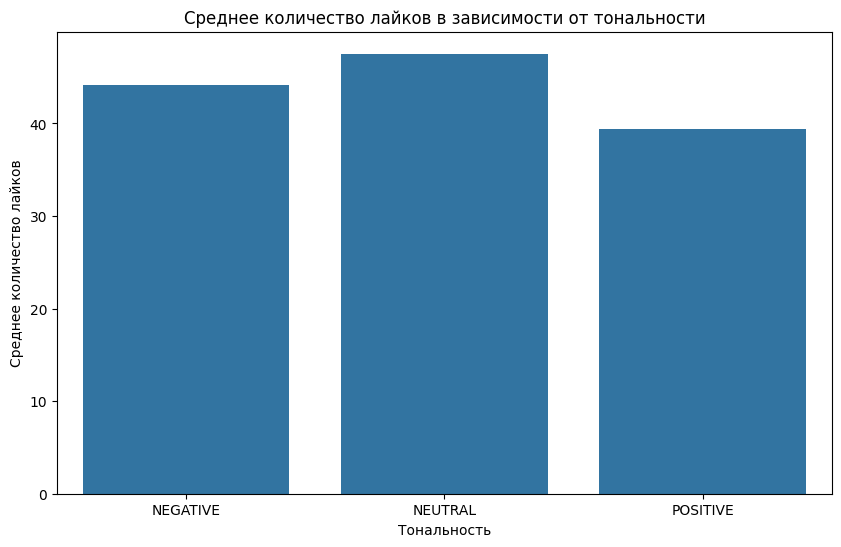

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Группировка данных по тональности и расчет средних значений показателей вовлеченности
grouped_data = data.groupby('sentiment')['likes', 'reposts', 'views'].mean().reset_index()

# Визуализация среднего количества лайков для каждой тональности
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='likes', data=grouped_data)
plt.title('Среднее количество лайков в зависимости от тональности')
plt.xlabel('Тональность')
plt.ylabel('Среднее количество лайков')
plt.show()

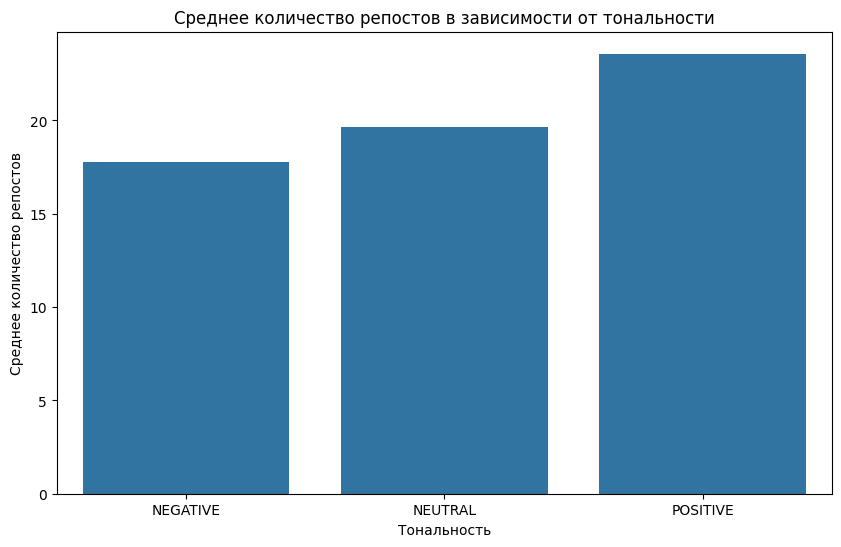

In [ ]:
# Визуализация среднего количества репостов для каждой тональности
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='reposts', data=grouped_data)
plt.title('Среднее количество репостов в зависимости от тональности')
plt.xlabel('Тональность')
plt.ylabel('Среднее количество репостов')
plt.show()

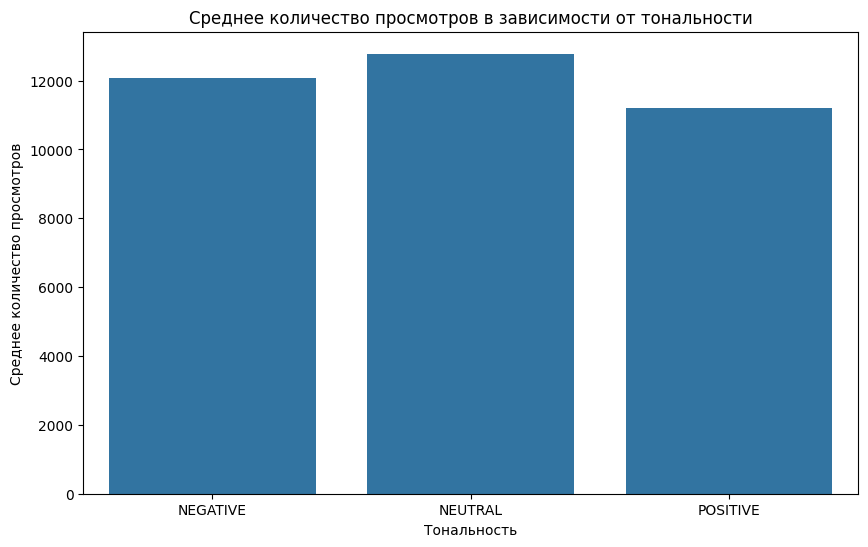

In [ ]:
# Визуализация среднего количества просмотров для каждой тональности
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='views', data=grouped_data)
plt.title('Среднее количество просмотров в зависимости от тональности')
plt.xlabel('Тональность')
plt.ylabel('Среднее количество просмотров')
plt.show()

In [ ]:
from scipy import stats

# Для примера проведем ANOVA для reposts
# Сначала получим отдельные группы для каждой категории тональности
data_positive = data[data['sentiment'] == 'POSITIVE']['reposts']
data_neutral = data[data['sentiment'] == 'NEUTRAL']['reposts']
data_negative = data[data['sentiment'] == 'NEGATIVE']['reposts']

# Проведение ANOVA
f_value, p_value = stats.f_oneway(data_positive, data_neutral, data_negative)

print(f"F-значение: {f_value}, p-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Существуют статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

F-значение: 35.09577795074372, p-значение: 6.071841394813904e-16
Существуют статистически значимые различия между группами.


In [ ]:
# Для примера проведем ANOVA для likes
# Сначала получим отдельные группы для каждой категории тональности
data_positive = data[data['sentiment'] == 'POSITIVE']['likes']
data_neutral = data[data['sentiment'] == 'NEUTRAL']['likes']
data_negative = data[data['sentiment'] == 'NEGATIVE']['likes']

# Проведение ANOVA
f_value, p_value = stats.f_oneway(data_positive, data_neutral, data_negative)

print(f"F-значение: {f_value}, p-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Существуют статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

F-значение: 1.5800382179764128, p-значение: 0.205991524902268
Нет статистически значимых различий между группами.


In [ ]:
# Для примера проведем ANOVA для views
# Сначала получим отдельные группы для каждой категории тональности
data_positive = data[data['sentiment'] == 'POSITIVE']['views']
data_neutral = data[data['sentiment'] == 'NEUTRAL']['views']
data_negative = data[data['sentiment'] == 'NEGATIVE']['views']

# Проведение ANOVA
f_value, p_value = stats.f_oneway(data_positive, data_neutral, data_negative)

print(f"F-значение: {f_value}, p-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Существуют статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

F-значение: 0.7170708043742271, p-значение: 0.48819200068422697
Нет статистически значимых различий между группами.
